# <font color=red>FIFA18 Multiple Regression</font>

### The following is a multivariate regression exercise, using data obtained from <a href="https://www.kaggle.com/thec03u5/fifa-18-demo-player-dataset/discussion">Kaggle</a> to try and predict player wages. We will first have to prepare the data for analysis by cleaning it.

#### <font color=blue>Import statements</font>

In [605]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

font = {'family' : 'DejaVu Sans',
        'size'   : 18}

plt.rc('font', **font)
plt.rcParams["figure.figsize"] = [16,9]

#### <font color=blue>Declare data types for columns so that Jupyter can optimise memory when loading.</font>

In [606]:
#specify data types
#acceleration to volleys have + and - after the numbers, so must be imported as string and then split,
#wage and value has characters after the number
dtype = {"Name":str, "Age":int, "Photo":str, "Nationality":str, "Flag":str, "Overall":int, "Potential":int, 
         "Club":str, "Club Logo":str, "Value":str, "Wage":str, "Special":int, "Acceleration":str, "Aggression":str, 
         "Agility":str, "Balance":str, "Ball control":str, "Composure":str, "Crossing":str, "Curve":str, "Dribbling":str, 
         "Finishing":str, "Free kick accuracy":str, "GK diving":str, "GK handling":str, "GK kicking":str, 
         "GK positioning":str, "GK reflexes":str, "Heading accuracy":str, "Interceptions":str, "Jumping":str, 
         "Long passing":str, "Long shots":str, "Marking":str, "Penalties":str, "Positioning":str, "Reactions":str, 
         "Short passing":str, "Shot power":str, "Sliding tackle":str, "Sprint speed":str, "Stamina":str, 
         "Standing tackle":str, "Strength":str, "Vision":str, "Volleys":str, "CAM":float, "CB":float, "CDM":float, "CF":float, 
         "CM":float, "ID":float, "LAM":float, "LB":float, "LCB":float, "LCM":float, "LDM":float, "LF":float, "LM":float, 
         "LS":float, "LW":float, "LWB":float, "Preferred Positions":str, "RAM":float, "RB":float, "RCB":float, "RCM":float, 
         "RDM":float, "RF":float, "RM":float, "RS":float, "RW":float, "RWB":float, "ST":float}

completedata = pd.read_csv("./fifa-18-demo-player-dataset/CompleteDataset.csv", dtype = dtype)
completedata.columns

Index(['Unnamed: 0', 'Name', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Acceleration', 'Aggression', 'Agility', 'Balance', 'Ball control',
       'Composure', 'Crossing', 'Curve', 'Dribbling', 'Finishing',
       'Free kick accuracy', 'GK diving', 'GK handling', 'GK kicking',
       'GK positioning', 'GK reflexes', 'Heading accuracy', 'Interceptions',
       'Jumping', 'Long passing', 'Long shots', 'Marking', 'Penalties',
       'Positioning', 'Reactions', 'Short passing', 'Shot power',
       'Sliding tackle', 'Sprint speed', 'Stamina', 'Standing tackle',
       'Strength', 'Vision', 'Volleys', 'CAM', 'CB', 'CDM', 'CF', 'CM', 'ID',
       'LAM', 'LB', 'LCB', 'LCM', 'LDM', 'LF', 'LM', 'LS', 'LW', 'LWB',
       'Preferred Positions', 'RAM', 'RB', 'RCB', 'RCM', 'RDM', 'RF', 'RM',
       'RS', 'RW', 'RWB', 'ST'],
      dtype='object')

#### <font color=blue>75 columns in the complete data set. We're trying to find out which of the following are most influential on Player wages:
 - Wage
 - Value
 - Overall
 - Potential
 - Stamina
 - Sprint speed
 - Free kick accuracy</font>

In [607]:
#select only variables of interest - we have chosen wage, player value, potential, stamina, speed and freekick accuracy
data = completedata.loc[:,["Wage", "Value", "Overall", "Potential", "Stamina", "Sprint speed", "Free kick accuracy"]] #select smaller data set
data.head()

,Wage,Value,Overall,Potential,Stamina,Sprint speed,Free kick accuracy
0,€565K,€95.5M,94,94,92,91,76
1,€565K,€105M,93,93,73,87,90
2,€280K,€123M,92,94,78,90,84
3,€510K,€97M,92,92,89,77,84
4,€230K,€61M,92,92,44,61,11


#### <font color=blue>We'll have to remove currency marks and convert all currency strings to floats to apply regression on the Wage and Value columns. Also, there are some zero values in those two columns. We're going to drop them.</font>

In [608]:
#drop euros and change K and M to zeros for value and wage categories,
#if converting to float it is NM to drop the full stop, otherwise the trailing digits are seen as decimals

#TODO fix this --> # I fixed it
def toNumberCurrency(string):
    """Function to convert Wage and Value strings to floats"""
    string = str(string) # this line is essential to avoid an exception being thrown if you run this cell more than once
    string = string.strip(" ")
    if string[-1] == 'M':
        return float(string[1:-1]) * 1000000
    elif string[-1] == 'K':
        return float(string[1:-1]) * 1000
    else:
        return float(string[1:])

data.Wage = data["Wage"].apply(toNumberCurrency)
data.Value = data["Value"].apply(toNumberCurrency)

# drop zero values
data = data[data['Wage'] != 0]
data = data[data['Value'] != 0]
data.reset_index(drop=True, inplace=True)

In [609]:
data[["Wage", "Value"]].min()

Wage      1000.0
Value    10000.0
dtype: float64

#### <font color=blue>We've now confirmed there's no zero values in the Wage and Value columns, which will come in handy when we later transform them by logging.</font>

In [610]:
def hasSpecialChar(value):
    return ("+" in value ) or ("-" in value)

submask = [value for value in data['Stamina'] if hasSpecialChar(value)]
subset = data[data['Stamina'].isin(submask)]
subset[['Overall', 'Potential', 'Sprint speed', 'Stamina', "Free kick accuracy"]].head()

,Overall,Potential,Sprint speed,Stamina,Free kick accuracy
306,81,89,73+7,68+2,22
408,80,86,83+1,82+1,74
621,79,80,69+2,85+2,69
738,78,81,89+1,73+3,57+5
893,78,80,73,75+1,73


#### <font color=blue>As can be seen from the above output, some of our predictor variables have non-integer values. We will deal with them by removing any extra chars.</font>

In [611]:
#split str on + and _
def removeExtraChars(string):
    sc = "" #special character: either '+' or '-'
    if "+" in string:
        sc = "+"
    elif "-" in string:
        sc = "-"
    else:
        return int(string)
    return int(string[:string.find(sc)])

def cleanUpColumn(df, column):
    return [removeExtraChars(str(row)) for row in df[column]]

data["Stamina"] = cleanUpColumn(data, "Stamina")
data["Free kick accuracy"] = cleanUpColumn(data, "Free kick accuracy")
data["Sprint speed"] = cleanUpColumn(data, "Sprint speed")
data["Free kick accuracy"] = cleanUpColumn(data, "Free kick accuracy")

data.head()

,Wage,Value,Overall,Potential,Stamina,Sprint speed,Free kick accuracy
0,565000.0,95500000.0,94,94,92,91,76
1,565000.0,105000000.0,93,93,73,87,90
2,280000.0,123000000.0,92,94,78,90,84
3,510000.0,97000000.0,92,92,89,77,84
4,230000.0,61000000.0,92,92,44,61,11


In [612]:
#examine null values
data.isnull().values.any()

False

#### <font color=blue>We've removed unncessary characters from the player attribute columns. Now let's run descriptive stats on the dataframe.</font>

In [613]:
#min, max, average
data.describe()

,Wage,Value,Overall,Potential,Stamina,Sprint speed,Free kick accuracy
count,17725.000000,1.772500e+04,17725.000000,17725.000000,17725.000000,17725.000000,17725.000000
mean,11711.537377,2.419841e+06,66.234640,71.216079,63.286827,64.860028,43.197405
std,23204.567109,5.384761e+06,6.999078,6.101176,15.903189,14.640443,17.559639
min,1000.000000,1.000000e+04,46.000000,46.000000,12.000000,11.000000,4.000000
25%,2000.000000,3.250000e+05,62.000000,67.000000,56.000000,57.000000,31.000000
50%,4000.000000,7.000000e+05,66.000000,71.000000,66.000000,67.000000,42.000000
75%,12000.000000,2.100000e+06,71.000000,75.000000,74.000000,75.000000,57.000000
max,565000.000000,1.230000e+08,94.000000,94.000000,95.000000,96.000000,93.000000


#### <font color=blue>Let's plot the histograms of all variables.</font>

In [614]:
#histograms and scatterplots
plt.rcParams["figure.figsize"] = [16,9]
# dropped.hist()

#### <font color=blue>From the histograms, it seems all the values are linearly distributed, except for the Value and Wage, which is what we're trying to predict anyway. We'll now apply a linear regression across the columns, treating all of them except Value as predictors</font>

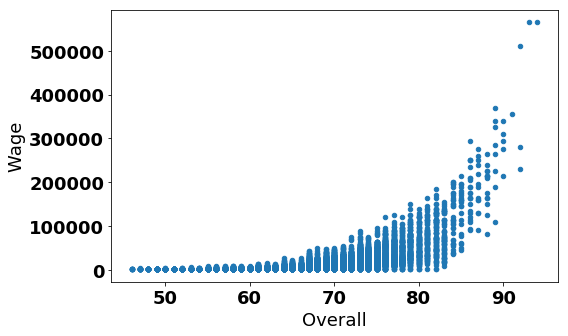

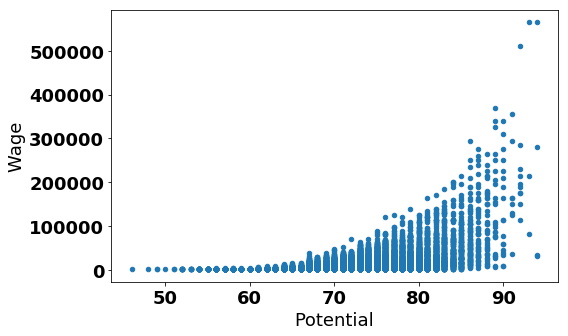

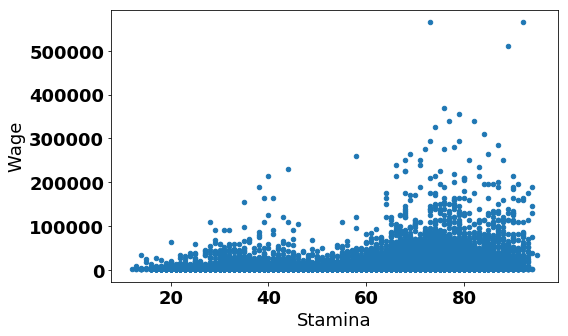

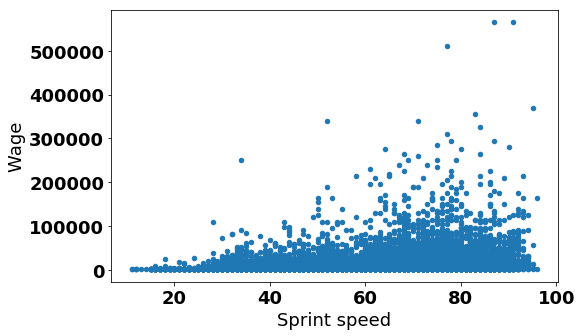

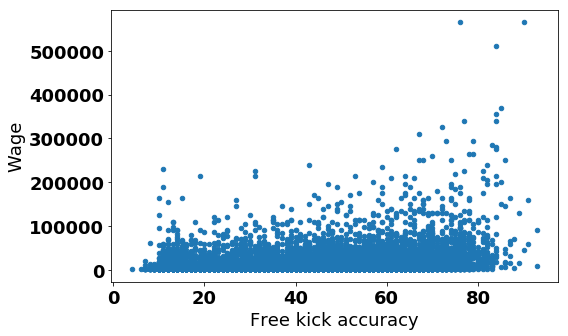

In [615]:
plt.rcParams["figure.figsize"] = [8,5]
outcome = "Wage"
predictors = ["Overall", "Potential", "Stamina", "Sprint speed", "Free kick accuracy"]

for predictor in predictors:
    data.plot.scatter(predictor, outcome)

#### <font color=blue>Wage versus Potential and Wage versus Overall are not linearly distributed, whilst there's no clear relationship between Wage and the other predictors. We will now log Wage to transform it.</font>

In [616]:
#log wage and add small constant
# Wage causes a non-linear graph when graphed against 'Overall' & 'Potential'. We'll have to transform it by logging

data['LogWage'] = data['Wage'].apply(np.log)
data['LogWage'].head()

0    13.244581
1    13.244581
2    12.542545
3    13.142166
4    12.345835
Name: LogWage, dtype: float64

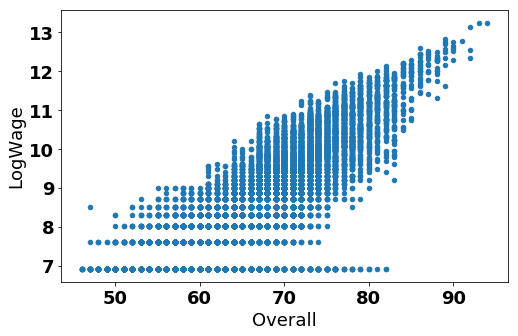

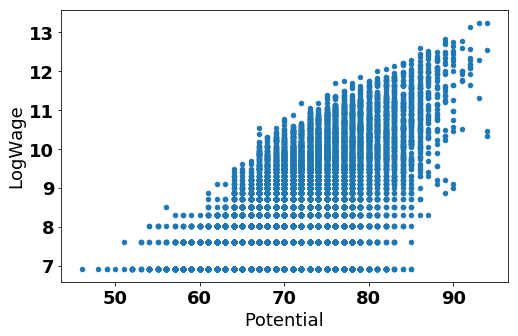

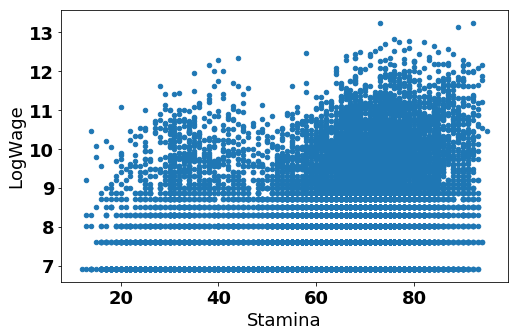

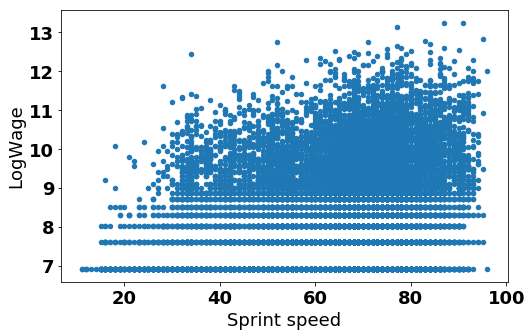

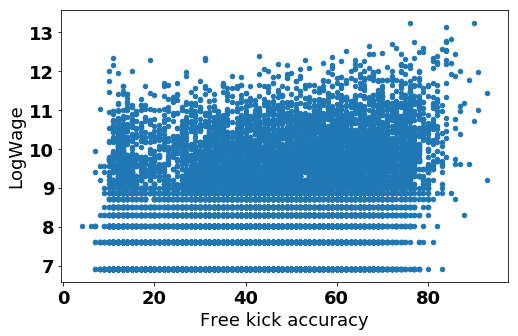

In [617]:
outcome = "LogWage"

for predictor in predictors:
    data.plot.scatter(predictor, outcome)

#### <font color=blue>Now our scatter plots are becoming more clear: the seems to be a strong positive, linear relationship between a player's Wage and both his Potential and Overall. The relationship between player Wage and other characteristics is not clear yet.</font>

In [618]:
#standardise predictor variables
transformed = data
for predictor in predictors:
    X = transformed[[predictor]]
    Y = data[outcome]
    scaler = StandardScaler().fit(X)
    rescaledX = scaler.transform(X)

#### <font color=blue>Now we use Sci-Kit Learn to apply linear regression on the predictor variables to statisticaly determine which of the variables is the key contributer to player Wage.</font>

In [619]:
#multiple regression
# get all of the predictor variable in one dataframe without the outcome variable
df = pd.DataFrame(data, columns=predictors)

# Put the target (log of wage) in another DataFrame
target = pd.DataFrame(data, columns=["LogWage"])

#specify variables
X = df #predictor variables
y = target["LogWage"] #outcome

#fit model
lm = linear_model.LinearRegression(fit_intercept=True, normalize=True)
model = lm.fit(X,y)

def coefficients(list1, list2):
    """A function to conveniently match predictors with their calculated coefficients"""
    [print(item + ": " + str(list2[i])) for i, item in enumerate(list1)]

#### <font color=blue>Now we output the outcomes...</font>

In [620]:
#get predicted y (Wage) values
predictions = lm.predict(X)
print("predictions\t=\t" + str(predictions))

#get R squared
print("lm.score(X,y)\t=\t" + str(lm.score(X,y)) + "\n")

print("intercept_\t=\t" + str(lm.intercept_) + "\n")

#see regression coefficients
coefficients(predictors, lm.coef_)

predictions	=	[12.80961922 12.70595946 12.59040502 ...  5.5378393   5.66566436
  5.60130805]
lm.score(X,y)	=	0.6757551960360024

intercept_	=	-2.301353721431987

Overall: 0.12548205257487038
Potential: 0.0323847215477005
Stamina: -0.0001926315861609725
Sprint speed: 0.0001314849418494561
Free kick accuracy: 0.0036480677972080973


#### <font color=blue>We have now statisticaly confirmed that a player's Overall is the biggest determinant to a player's Wage, followed by the player's Potential. Our LinearModel Score shows our prediction is 67.5% correct.</font>

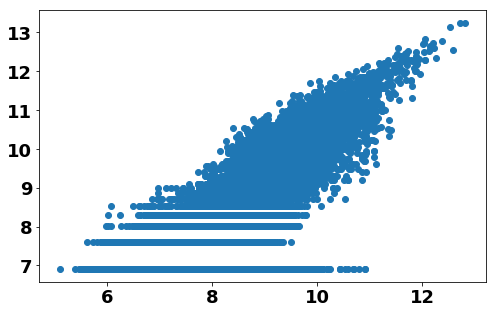

In [659]:
#get regression diagnostics

#E.g. get average difference between observed Y and predicted Y
observedY = data['LogWage']
residuals = []
sum = 0
index = 0
for i, value in enumerate(predictions):
    sum += value - observedY[i]
    residuals.append((value - observedY[i]))
    index = i
avg = sum / index
avg

#get scatterplot of predicted Y vs residuals
# plt.scatter(predictions, residuals)
plt.scatter(predictions, observedY)
# plt.xlabel("Predictions")
# plt.ylabel("Residuals")
# plt.title("Predicted Y vs Residuals")